In [1]:
import spikeinterface.full as si
from spikeinterface.sorters import get_default_sorter_params, get_sorter_params_description
import probeinterface as pi
from spikeinterface_gui import run_mainwindow
from pathlib import Path
import json
import woodsort
import warnings


In [2]:
# Spike sorting pipeline for the H7100 dataset
# Experimenter: Trisha Narayanan 
# Acquired: Dec 2024 - May 2025

### Parameters set manually ### 

# path to the recording folder (the folder containing the OpenEphys folder YYYY-MM-DD_hh-mm-ss)
#recfolder_path ='/home/avadher/SIDB_Datastore/Trisha/Raw/H7100/H7113/H7113-250604'
session_path = '/home/avadher/Data/H7113-250604/'

# set parameters for probe
shank_groups = [0, 1] # specify which groups in the xml file are shanks to be sorted (0-base)
probe_manufacturer = "cambridgeneurotech"
probe_name = "ASSY-156-H7" 

# Set paths 
session_path = Path(session_path)
session_name = session_path.name






Sync metadata written to: /home/avadher/Data/H7113-250604/MetadataOpenephys.txt
['Software Time (milliseconds since midnight Jan 1st 1970 UTC): 1749044772720 Start Time for Acquisition Board (100) - Rhythm Data @ 30000 Hz: 0', 'Software Time (milliseconds since midnight Jan 1st 1970 UTC): 1749045560326 Start Time for Acquisition Board (100) - Rhythm Data @ 30000 Hz: 0', 'Software Time (milliseconds since midnight Jan 1st 1970 UTC): 1749051166868 Start Time for Acquisition Board (100) - Rhythm Data @ 30000 Hz: 0']


Using XML file: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/continuous.xml
Probe updated with Neuroscope mapping
Device channel indices before adding to the recording
[22  4 13  6 15 29 24  2 11 16 20 30  7  1  9  0 21 62  8 31 25 19 12  3
 10 28 23 18 14  5 27 26 36 37 59 48 44 41 34 52 61 50 45 39 33 54 47 43
 17 55 63 57 32 42 46 53 60 38 35 49 56 51 58 40]
Device channel indices after adding to the recording
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Device channel indices before splitting by group
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Device channel indices after splitting by group
[ 0

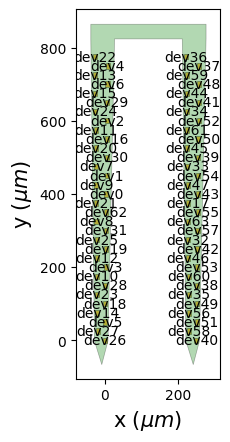

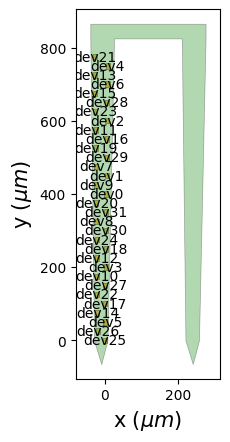

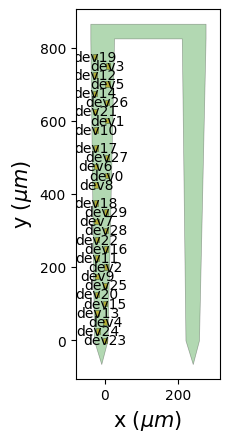

In [3]:
# Load recording and probe, preprocess and fill channel indices from Neuroscope
recording = si.read_openephys(session_path,stream_id='0')
probe = pi.get_probe(manufacturer=probe_manufacturer, probe_name=probe_name) # pi.list_all_probes() to list all probes 


### Spike sorting ### 

# Load recording and probe, preprocess and fill channel indices from Neuroscope
recording = si.read_openephys(session_path,stream_id='0')
probe = pi.get_probe(manufacturer=probe_manufacturer, probe_name=probe_name) # pi.list_all_probes() to list all probes 


# Load Neuroscope channel mapping
channel_mapping = woodsort.neuroscope.load_neuroscope_channels(session_path)

# Get channel indices corresponding to the probe
neuroscope_channel_indices = (
    channel_mapping.loc[
        channel_mapping["channel_group"].isin(shank_groups),
        "channel_0based",
    ].tolist()
)

# Add neuroscope mapping to probe
probe = neuroscope.add_neuroscope_mapping(
    probe,
    neuroscope_channel_indices
)

    print('Device channel indices before adding to the recording')
    print(probe.device_channel_indices)

    # Sort channel IDs so they are labelled in descending fashion (RESETS AFTER PROBE ADDED TO REC):
    #probe.set_contact_ids(np.sort(probe.contact_ids.astype(int)).astype(str))
    #print(probe.contact_ids)

    # Attach probe
    recording = recording.set_probe(probe, group_mode="by_shank")
    p = recording.get_probe()
    print('Device channel indices after adding to the recording')
    print(p.device_channel_indices)

    #print(p.contact_ids)

    if plot_probe:
        si.plot_probe_map(recording, with_device_index=True)
        # si.plot_probe_map(recording, with_channel_ids=True)

    # now concatenate all recordings and split by shank
    recording = si.concatenate_recordings([recording])


    p = recording.get_probe()
    print('Device channel indices before splitting by group')
    print(p.device_channel_indices)

    recording = recording.split_by("group")

    p = recording[0].get_probe()
    print('Device channel indices after splitting by group')
    print(p.device_channel_indices)

    if plot_probe:
        si.plot_probe_map(recording[0], with_device_index=True)
    # si.plot_probe_map(recording, with_channel_ids=True)


    for group_id, rec_g in recording.items():
        if plot_range is not None:
            si.plot_traces(
                rec_g,
                order_channel_by_depth=True,
                time_range=list(plot_range)
            )

    # filter + bad channel removal
    recording = si.bandpass_filter(recording)
    recording = si.detect_and_remove_bad_channels(recording)

    if plot_probe:
        si.plot_probe_map(recording[0], with_device_index=True)
    # si.plot_probe_map(recording, with_channel_ids=True)





Using XML file: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/continuous.xml
Probe updated with Neuroscope mapping
write_binary_recording 
engine=process - n_jobs=12 - samples_per_chunk=30,000 - chunk_memory=3.43 MiB - total_memory=41.20 MiB - chunk_duration=1.00s
Using training recording of duration 300 sec with the sampling mode uniform
*** MS5 Elapsed time for SCHEME2 get_sampled_recording_for_training: 0.186 seconds ***
Running phase 1 sorting
Number of channels: 30
Number of timepoints: 9000000
Sampling frequency: 30000.0 Hz
Channel 0: [  4.5 450. ]
Channel 1: [  6. 600.]
Channel 2: [  2. 200.]
Channel 3: [  7.5 750. ]
Channel 4: [ 0.5 50. ]
Channel 5: [  7. 700.]
Channel 6: [-24.5 475. ]
Channel 7: [-23. 325.]
Channel 8: [-24. 425.]
Channel 9: [-21.5 175. ]
Channel 10: [-25.5 575. ]
Channel 11: [-22. 225.]
Channel 12: [-27. 725.]
Channel 13: [-20.5  75. ]
Channel 14: [-26.5 675. ]
Channel 15

FileNotFoundError: [Errno 2] No such file or directory: 'params/default_analyzer_metrics.json'

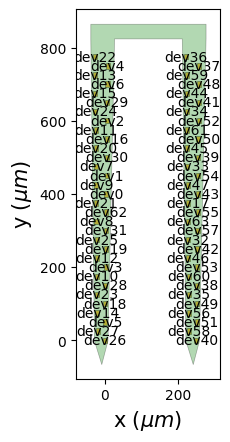

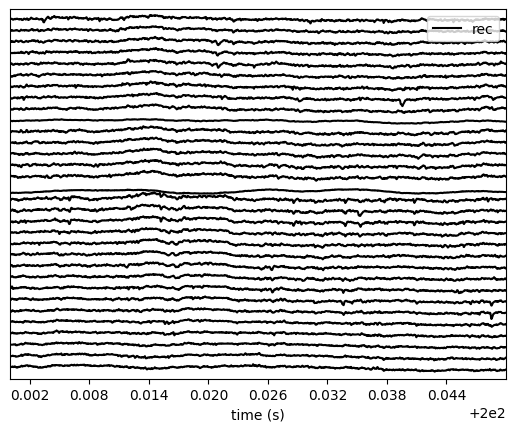

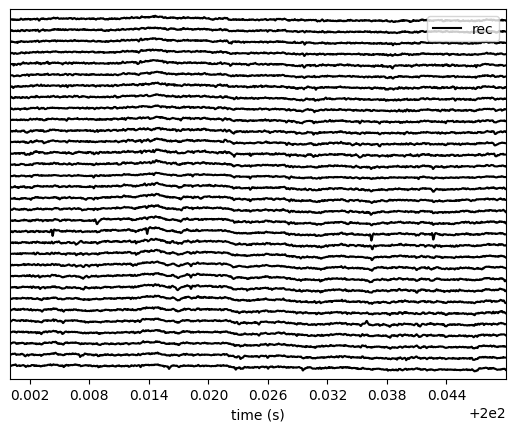

In [4]:
### Manual curation ###

analyzer = si.load_sorting_analyzer(analyzer_path)
run_mainwindow(analyzer, mode="desktop", curation=True)



In [8]:
print(dir(analyzer.recording))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_annotations', '_check_segment_index', '_dtype', '_extra_metadata_from_folder', '_extra_metadata_to_folder', '_get_common_repr_html', '_get_file_path', '_get_t_starts', '_get_time_vectors', '_kwargs', '_main_annotations', '_main_features', '_main_ids', '_main_properties', '_perform_consistency_checks', '_precomputable_kwarg_names', '_preferred_mp_context', '_properties', '_recording_segments', '_recordings', '_remove_channels', '_repr_header', '_repr_html_', '_sampling_frequency', '_save', '_select_segments', '_serializability', '_set_probes', '_skip_properties', 'add_recording_segment', 'annotate', 'astype', 'binary_compatible_with', 'channel_id

In [24]:
# default curation path
curation_path = analyzer_path / "spikeinterface_gui/curation_data.json"
with open(curation_path, "r") as f:
    curation_dict = json.load(f)

curated_analyzer = si.apply_curation(analyzer, curation_dict, merging_mode='hard')
run_mainwindow(curated_analyzer, mode="desktop", curation=True)

compute_waveforms (workers: 12 processes):   0%|          | 0/10315 [00:00<?, ?it/s]

noise_level (workers: 12 processes):   0%|          | 0/20 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/78 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/78 [00:00<?, ?it/s]

Compute : spike_amplitudes + spike_locations (workers: 12 processes):   0%|          | 0/10315 [00:00<?, ?it/s…

/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


noise_level (workers: 12 processes):   0%|          | 0/20 [00:00<?, ?it/s]

calculate_pc_metrics:   0%|          | 0/78 [00:00<?, ?it/s]


Extracting recording boundaries...
Extracting start and end times: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording1
Extracting start and end times: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording2
Extracting start and end times: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording3

Epoch timestamps saved to: /home/avadher/Data/H7113-250604/EpochTimestamps.csv


Aligning Bonsai tracking data...

Recording path: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording1
TTL pulses:         25592
Bonsai frames:      25591
Trimming 1 extra TTL pulses at the end

Recording path: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording2
TTL pulses:         216494
Bonsai frames:      216480
Trimming 14 extra TTL pulses at the end

Recording path: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Nod

Extracting LFP: 100%|██████████| 194/194 [00:26<00:00,  7.22it/s]



[2] recording folder: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording2


Extracting LFP: 100%|██████████| 1625/1625 [03:46<00:00,  7.19it/s]



[3] recording folder: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording3


Extracting LFP: 100%|██████████| 1274/1274 [02:57<00:00,  7.19it/s]



Done. Processed 3 recording folder(s).
Merged 3 LFP files into /home/avadher/Data/H7113-250604/continuous.lfp.
Component LFP files removed.
Copied XML file.
LFP extraction done.



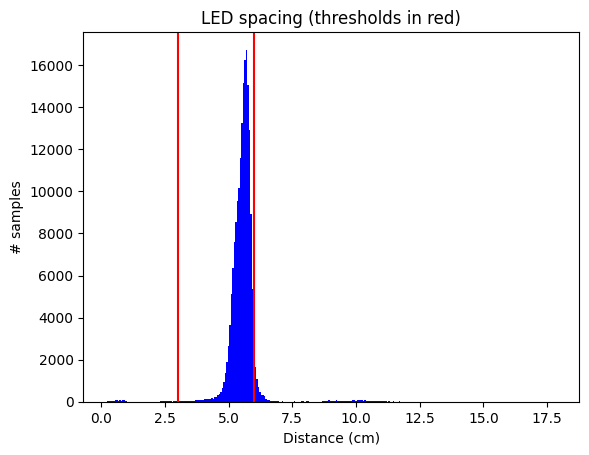

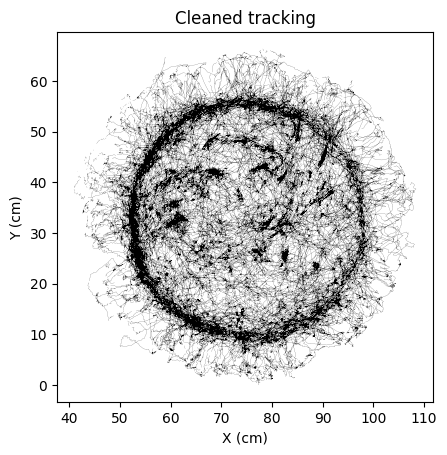

In [5]:
### Get other data from the recording ###

# get epochs
epochs = woodsort.helper_functions.get_epochs_openephys(
    recfolder_path, 
    save_path =recfolder_path)

# get OpenEphys metadata
woodsort.helper_functions.get_metadata_openephys(
        recfolder_path, 
        save_path =recfolder_path)

# align tracking
aligned_tracking = woodsort.tracking.align_tracking_bonsai(
    recfolder_path=recfolder_path, 
    ttl_channel=ttl_channel, 
    column_names=column_names, 
    save_path=recfolder_path)

# process tracking
processed_tracking = woodsort.tracking.process_tracking_bonsai(
        aligned_tracking,   
        pixel_width=pixel_width,      # conversion factor: cm per pixel
        min_spacing=min_spacing,      # minimum allowed LED spacing (cm)
        max_spacing=max_spacing,  
        save_path=recfolder_path,  # maximum allowed LED spacing (cm)
        plot=True)             # whether to show diagnostic plot

# Extract LFP
woodsort.lfp.extract_lfp_openephys(recfolder_path)


In [9]:
# Apply curation and export to pynapple 

units = hf.export_to_pynapple(
    sorting_analyzer_or_sorting=analyzer, 
    attach_unit_metadata=True
)

print(units)

Index    rate      x          y          z        num_spikes    ...
-------  --------  ---------  ---------  -------  ------------  -----
0        7.48989   23.93879   447.43181  1.0      77254         ...
1        2.75701   24.23031   611.94237  1.0      28437         ...
2        6.05345   0.05848    610.84718  1.0      62438         ...
3        4.43252   2.10976    591.7677   1.0618   45719         ...
4        0.94499   -1.72095   191.91471  1.0      9747          ...
5        2.99473   -10.31764  199.32296  4.83738  30889         ...
6        11.34952  -1.2704    753.58114  1.0      117064        ...
...      ...       ...        ...        ...      ...           ...
74       1.32717   232.84144  178.82289  1.21006  13689         ...
75       3.54008   236.69796  177.62936  8.98377  36514         ...
76       2.23968   239.79668  586.03995  1.06508  23101         ...
77       1.49189   195.9344   556.54178  1.0      15388         ...
78       1.8923    212.24701  576.74093  1.0  

In [10]:
p = recording.get_probe()
print(p.device_channel_indices)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_annotations', '_channel_ids', '_check_segment_index', '_dtype', '_extra_metadata_from_folder', '_extra_metadata_to_folder', '_get_common_repr_html', '_get_file_path', '_get_t_starts', '_get_time_vectors', '_kwargs', '_main_annotations', '_main_features', '_main_ids', '_main_properties', '_parent', '_parent_channel_indices', '_precomputable_kwarg_names', '_preferred_mp_context', '_properties', '_recording_segments', '_remove_channels', '_renamed_channel_ids', '_repr_header', '_repr_html_', '_sampling_frequency', '_save', '_select_segments', '_serializability', '_set_probes', '_skip_properties', 'add_recording_segment', 'annotate', 'astype', 'bina